# <center> Study Project-4: Classification

**Business Task**

Banks often need to run a marketing campaign in order to sell a product to potential customers.
Our task to define customer characteristics which one is ready to open deposit.

**Technical Task**
* Using the data to build a model that predicts whether the client will open a deposit - 1/0

**Task**
* Binary classification

**Metrics:** F1_score

**Data:** The csv file contains 17 fields (16 + 1 target)

# <p style="text-align:center;font-size:100%;">0. Install and Import</p>

In [1]:
# Installing libs: Optimisation of Hypermarameters
# !pip install optuna
import optuna

# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Libs for feature engineering
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn import metrics

# Model
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# Optimisation of Hypermarameters
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

## <center> 1. Checking dataset: outliers, duplicates

In [3]:
# Reading csv-file
bank_df = pd.read_csv('data/bank_fin.csv', sep = ';')
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


*Bank`s customer details:*

* age;
* job - job title;
* marital - marital status;
* education - degree of education;
* default - is there an outstanding loan?;
* housing - do you have a home loan?;
* loan - do you have a personal loan?;
* balance.

*Data related to the last contact in the context of the current marketing campaign:*
* contact - mobile or landline?;
* month - month of last call;
* day - day of last contact;
* duration - duration of the conversation in seconds.

DURATION

*Important note*: this attribute greatly affects the final result (for example, if duration=0, then 'deposit'=’no’); The duration is not known before the call is made, and after the end of the call, 'deposit' is obviously known. Thus, these inputs should only be included for comparison purposes and discarded when a realistic predictive model is needed;

*Other features:*
* campaign - number of contacts during this campaign and for this client;
* pdays - number of days since the last contact with the client, since the previous campaign;
* previous - number of contacts before this campaign for this client;
* poutcome - the outcome of the previous campaign.

**deposit** - target value - Y - whether the client will open a deposit? (0 – no, 1 – yes).

In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
"""
Let`s check our data for Missing values (MV)
"""
print(f'Total number of rows, columns: {bank_df.shape}')

# duplicates
all_columns = list(bank_df.columns)
mask_dupl = bank_df.duplicated(subset=all_columns) 
data_duplicates = bank_df[mask_dupl]
print(f'\nNumber of found duplicates: {data_duplicates.shape[0]}')

# features with missing values
nulls_data = bank_df.isnull().sum()
nulls = nulls_data[nulls_data > 0]
print(f'\nFeatures with nulls: {nulls_data[nulls_data>0].count()}\n{nulls}')

Total number of rows, columns: (11162, 17)

Number of found duplicates: 0

Features with nulls: 1
balance    25
dtype: int64


The set is dedicated to the bank’s clients and contains 11162 records with 17 fields (16 + 1 target)

We define only 1 column with explicit missing values (MV): ***balance***.

But, as we know, that there is implicit MV too - special words/ symbols. Let's look at the example.

In [6]:
"""
Define Unique category in each column
"""
unique_list = []

for col in bank_df.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, bank_df[col].nunique(), bank_df[col].dtypes, bank_df[col].unique())
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Unique_category']
).sort_values(by='Num_Unique', ignore_index=True)


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
0,deposit,2,object,"[yes, no]"
1,loan,2,object,"[no, yes]"
2,housing,2,object,"[yes, no]"
3,default,2,object,"[no, yes]"
4,contact,3,object,"[unknown, cellular, telephone]"
5,marital,3,object,"[married, single, divorced]"
6,poutcome,4,object,"[unknown, other, failure, success]"
7,education,4,object,"[secondary, tertiary, primary, unknown]"
8,job,12,object,"[admin., technician, services, management, ret..."
9,month,12,object,"[may, jun, jul, aug, oct, nov, dec, jan, feb, ..."


Some of columns/features consist of *unknown* values as NaN:
* contact
* poutcome
* education
* job

In [7]:
"""
Look at the distibution of categories in Job column
"""
bank_df.job.value_counts(True)

management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: job, dtype: float64

So, we found different type of MV (explicit/ implicit). Next step is processing of this data.

But some of the data has uncorrect type. We should to solve it.

In [8]:
bank_df.balance.iloc[:5]

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

Column ***balance***: there are two extra symbols - comma(,) and $.

It`s necessary to change it in order to get numeric type.

***

In [9]:
# Let's make a copy of the given DataFrame in order to protect original DF
bank_copy = bank_df.copy()

***

### `BALANCE`

In [10]:
"""
Function to get float type from string by next steps:
- delete comma and extra symbols (,00)
- delete $ sign
- delete space
"""
def get_float(row):
    row = row.replace(',00', '') # delete 00 values
    row = row.replace('$', '') # delete $ sign
    row = row.replace(' ', '') # delete space
    
    return float(row)


bank_copy['balance'] = bank_copy['balance'].astype(str).apply(get_float)

# Check what we get
display(bank_copy['balance'])

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

The values in column of ***balance*** have correct views.

There is less than 1% of MV in ***balance*** column (total number of rows in dataset - 11_162, number of MV - 25).

We have 2 strategies to process it:
* deleting rows with MV (but we may lose part of information),
* replacing MV to median values

Let`s use strategy #2

In [11]:
"""
Filling MV in Balance column by median value
"""
print(f'Mean value of balance before processing MV: {round(bank_copy.balance.mean(), 3)}')

bank_copy.balance = bank_copy.balance.fillna(bank_copy.balance.median())
print(f'\nMean value of balance after processing MV: {round(bank_copy.balance.mean(), 3)}')

Mean value of balance before processing MV: 1529.129

Mean value of balance after processing MV: 1526.936


***

Some steps earlier we found columns with *implicit type* of MV:
* contact
* poutcome
* education
* job

We need to fill MV in this type of data - categorical - by mode value.

In [12]:
print('Distribution (%) of values in CONTACT column:')
display(bank_copy.contact.value_counts(True))

print('Distribution (%) of values in POUTCOME column:')
display(bank_copy.poutcome.value_counts(True))

print('Distribution (%) of values in EDUCATION column:')
display(bank_copy.education.value_counts(True))

print('Distribution (%) of values in JOB column:')
display(bank_copy.job.value_counts(True))

Distribution (%) of values in CONTACT column:


cellular     0.720480
unknown      0.210177
telephone    0.069342
Name: contact, dtype: float64

Distribution (%) of values in POUTCOME column:


unknown    0.745924
failure    0.110016
success    0.095951
other      0.048110
Name: poutcome, dtype: float64

Distribution (%) of values in EDUCATION column:


secondary    0.490593
tertiary     0.330496
primary      0.134385
unknown      0.044526
Name: education, dtype: float64

Distribution (%) of values in JOB column:


management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: job, dtype: float64

*Unknown* value describes a significant part of the data (21/ 75%) in ***contact*** and ***poutcome*** columns

It means that we can replace *'unknown'* values only in ***education*** and ***job*** columns

***

### `JOB, EDUCATION`

In [13]:
"""
Replacing unknown value in Job and Education columns by mode
"""
m_job = bank_copy.job.mode()[0]
m_edu = bank_copy.education.mode()[0]

bank_copy.job = bank_copy.job.apply(lambda x: m_job if x == 'unknown' else x)
bank_copy.education = bank_copy.education.apply(lambda x: m_edu if x == 'unknown' else x)

***

Let`s look at the ***balance*** column for more details:
- checking to outliers

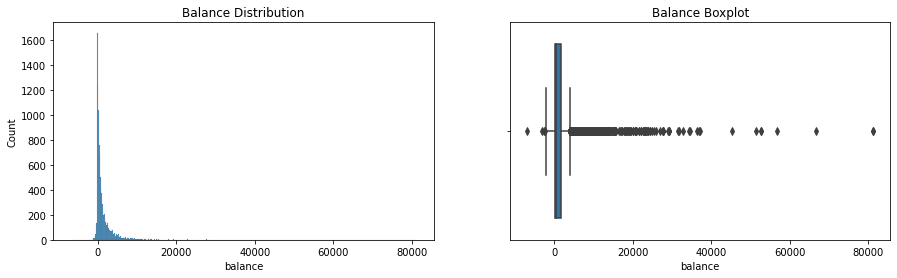

In [14]:
# Building histogram and box plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

histplot = sns.histplot(data=bank_copy, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');

boxplot = sns.boxplot(data=bank_copy, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

It is usual graph`s view of data with outliers:
* Histogram: seaborn automatically selects the number of bins needed to best visualize the distribution. If there are outlier values, the number of bins will be very large, and as the result we get this type of pictures.
* Box plot: narrow pic as usual for data with outliers

In [15]:
"""
Checking outliers by Tukey’s method:
- calculate 1 and 3 quartiles,
- calculate interquartile range (IQR),
- calculate lower and upper bounds,
- defining data set lies beyond either boundary
"""
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    # we should use strict equality
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    # we should use strict inequality
    cleaned_df = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned_df


outliers, bank_cleaned = outliers_iqr(bank_copy, 'balance')

print(f'Number of outliers by Tukey’s method: {outliers.shape[0]}')
print(f'Final number of rows (after removing outliers): {bank_cleaned.shape[0]}')

Number of outliers by Tukey’s method: 1057
Final number of rows (after removing outliers): 10105


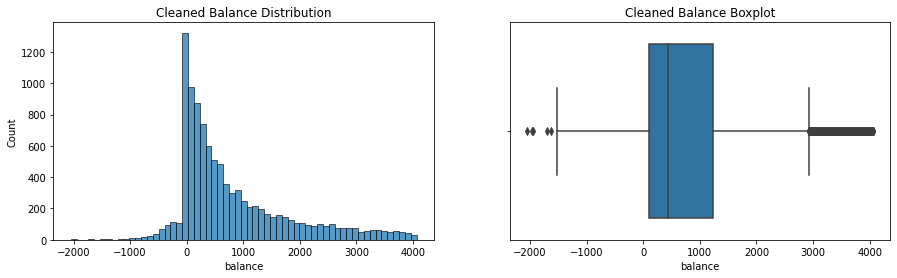

In [16]:
# Let`s build histogram and boxplot based on the cleaned dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

histplot = sns.histplot(data=bank_cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Balance Distribution');

boxplot = sns.boxplot(data=bank_cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Balance Boxplot');

* Box plot shows that there are some outliers in data by left anf right side from the boundaries.
* As you can see, we cut the range of ***balance*** value: max ~ 4_000, min - there are negative values.

In [17]:
"""
Lower and Upper boundaries of box plot by Tukey’s method
"""
Q1 = bank_copy['balance'].quantile(q=.25)
Q3 = bank_copy['balance'].quantile(q=.75)

IQR = Q3 - Q1
lower_bound = Q1 - (IQR*1.5)
upper_bound = Q3 + (IQR*1.5)

print(f'Lower bound: {lower_bound}. Upper bound: {upper_bound}')

Lower bound: -2241.0. Upper bound: 4063.0


# <p style="text-align:center;font-size:100%;">2. Feature Engineering</p>

***Our data***
- Cleaned Dataset (without outliers) - *bank_cleaned*

***

First step: we need to check target value - (un-)/balanced?

In [18]:
"""
Grouped data by 'deposit' category
Calculate the number of customer by 2 group - open deposit/ no
Building Pie chart in order to illustrate distibution of 2 classes
"""
pie_data = bank_cleaned.groupby('deposit')['deposit'].count()
pie_data.index = ['Don\'t open a deposit', 'Open a deposit']

# building Pie chart (Plotly)
fig = px.pie(
    values=pie_data,
    names=pie_data.index,
    hole=0.8
);

fig.update_layout(
    annotations=[dict(text='Ratio of Сlients<br>who opened a deposit<br>and didn`t',
                      x=0.5, y=0.5, font_size=14, showarrow=False)]
    )

fig.write_image('data/fig1.png')
fig.show()

In [19]:
count_no_dep = len(bank_cleaned[bank_cleaned['deposit']=='no'])
count_dep = len(bank_cleaned[bank_cleaned['deposit']=='yes'])

pct_of_no_dep = count_no_dep/(count_no_dep+count_dep)
print(f'Percentage of no subscription is {round(pct_of_no_dep*100)} %')

pct_of_dep = count_dep/(count_no_dep+count_dep)
print(f'Percentage of subscription is {round(pct_of_dep*100)} %')

Percentage of no subscription is 54 %
Percentage of subscription is 46 %


* ~ 46% of customer who opened a deposit,
* ~ 54% of customer didn`t open a deposit.

Based on this result we can conclude that our classes are balanced. The ratio of clients without a deposit to those with a deposit is 54 to 46. 

***

Let`s look at the Descriptive statistics of numerical features

In [20]:
# Statistic information of Numeric data
bank_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [21]:
print(f'Maximum age of bank client: {bank_cleaned.age.max()}')
print(f'Minimum duration time of conversation with client: {bank_cleaned.duration.min()}')

Maximum age of bank client: 95
Minimum duration time of conversation with client: 2


Let`s look at the Descriptive statistics of Categorical features.

In [22]:
bank_cleaned.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Top Customer Characteristics:
* *job title* - management
* *marital status* - married
* *education level* - secondary	
* *default, housing, loan* - no

***

Let’s do some more research

In [23]:
bank_cleaned.groupby('deposit').mean()

,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,
no,40.629978,682.155420,16.036320,221.316740,2.845870,36.253872,0.522124
yes,41.203162,953.071566,15.073489,539.568896,2.136296,68.776757,1.157018


Here are the new observations:

* The average ***age*** of clients who opened a deposit is higher than the average age of those who did not.
* ***Balance*** value of clients who opened a deposit is higher than the average balance of those who did not.
* The ***number of days*** since the last contact with the client is less for clients who have opened a deposit. And the smaller it is, the better the last call was remembered, which means the higher the chance of opening an account.
* ***Duration*** of conversation time with clients who opened a deposit is higher than the average duration of those who did not.
* The ***campaign*** (the number of calls per campaign) is less for clients who have opened a deposit.
* ***Previous***: if the value is closer to 1, = / > 1, then the *deposit* value is 'yes' (1)

We can look at the differences in the result of **current and past marketing campaign**.

*Note*: Probably, people who have already agreed to a bank offer once are more likely to accept it again.

In [24]:
marketing_data = bank_cleaned.groupby('poutcome')['deposit'].value_counts()
marketing_data 

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

To present the data more clearly, we calculate the categorical mean of other categorical variables, such as *education* and *marital status*.

### `JOB, MARITAL STATUS, EDUCATION, MONTH`

In [25]:
"""
Group by Job column
"""
bank_cleaned.groupby(['job', 'deposit']).mean()

age      balance        day    duration  \
job           deposit                                                  
admin.        no       39.218750   627.931548  15.529762  207.313988   
              yes      38.952962   856.616725  15.139373  510.411150   
blue-collar   no       39.669264   654.830303  15.341126  232.691775   
              yes      38.473926   786.217791  15.035276  676.151840   
entrepreneur  no       42.952381   664.370370  15.698413  209.222222   
              yes      42.540541   917.567568  14.693694  643.540541   
housemaid     no       46.509804   646.751634  16.183007  210.973856   
              yes      49.525253  1070.666667  16.141414  557.343434   
management    no       40.432203   716.159322  16.545763  214.656780   
              yes      39.789427  1048.597357  14.692511  497.410573   
retired       no       61.324675   911.774892  15.584416  252.588745   
              yes      67.046296  1278.337963  15.337963  443.002315   
self-employed no       40.629442   754.005076  16.340102  229.253807   
              yes      37.416149   987.360248  14.826087  597.788820   
services      no       38.374761   625.787763  16.059273  225.908222   
              yes      37.275362   776.307246  15.072464  624.846377   
student       no       27.012346   830.444444  13.641975  219.592593   
              yes      25.693878   851.791837  15.575510  372.648980   
technician    no       38.872222   654.171111  16.930000  213.608889   
              yes      38.945799   942.355014  15.279133  544.831978   
unemployed    no       40.888112   766.846154  16.076923  248.496503   
              yes      41.042328   930.328042  15.111111  551.037037   

                       campaign      pdays  previous  
job           deposit                                 
admin.        no       2.668155  52.412202  0.715774  
              yes      2.045296  79.418118  1.336237  
blue-collar   no       2.718615  40.260606  0.533333  
              yes      2.199387  55.107362  0.900307  
entrepreneur  no       2.544974  27.121693  0.444444  
              yes      2.936937  47.117117  0.765766  
housemaid     no       2.764706  18.450980  0.307190  
              yes      2.515152  60.888889  0.838384  
management    no       3.000847  32.444068  0.482203  
              yes      2.198238  75.401762  1.275771  
retired       no       2.675325  29.965368  0.523810  
              yes      1.849537  67.365741  1.206019  
self-employed no       2.979695  31.700508  0.685279  
              yes      2.149068  59.987578  1.000000  
services      no       2.898662  36.432122  0.453155  
              yes      2.142029  71.704348  1.000000  
student       no       2.679012  42.962963  1.111111  
              yes      1.995918  74.167347  1.330612  
technician    no       3.075556  33.352222  0.464444  
              yes      2.142276  63.276423  1.165312  
unemployed    no       2.461538  20.755245  0.237762  
              yes      1.947090  80.539683  1.232804

In [26]:
"""
Group by Marital status column
"""
bank_cleaned.groupby(['marital', 'deposit']).mean()

age      balance        day    duration  campaign  \
marital  deposit                                                            
divorced no       45.386218   608.165064  15.844551  210.626603  2.766026   
         yes      48.575045   855.567812  15.482821  594.757685  2.083183   
married  no       42.783833   694.335755  16.165002  222.747805  2.959431   
         yes      46.026534  1029.008706  14.834163  541.496683  2.223051   
single   no       33.895124   686.122244  15.832331  222.615230  2.628591   
         yes      32.047786   877.756410  15.277972  519.074009  2.031469   

                      pdays  previous  
marital  deposit                       
divorced no       34.464744  0.419872  
         yes      61.763110  0.924051  
married  no       33.397215  0.492583  
         yes      71.308458  1.248756  
single   no       43.302605  0.629927  
         yes      67.478438  1.103147

In [27]:
"""
Group by Education column
"""
bank_cleaned.groupby(['education', 'deposit']).mean()

age      balance        day    duration  campaign  \
education deposit                                                            
primary   no       45.718750   673.590144  15.435096  224.287260  2.873798   
          yes      51.135397   973.707930  15.526112  641.094778  2.288201   
secondary no       39.909328   661.233855  15.961187  221.433790  2.811155   
          yes      40.520196   897.025704  15.056304  551.794778  2.092615   
tertiary  no       39.303408   728.860419  16.515072  219.461992  2.900393   
          yes      39.182720  1027.035026  14.961471  491.434326  2.152948   

                       pdays  previous  
education deposit                       
primary   no       30.707933  0.473558  
          yes      55.288201  1.027079  
secondary no       38.736138  0.541748  
          yes      72.321093  1.151367  
tertiary  no       34.290301  0.509174  
          yes      67.776416  1.204320

In [28]:
# Job: open a deposit/ do not
job_data = bank_cleaned.groupby('job', as_index=False)['deposit'].value_counts()

# Graph (Plotly) - bar chart
fig = px.bar(
    data_frame=job_data,
    x='job',
    y='count',
    color='deposit',
    barmode='group',
    height=400,
    width=800,
    color_discrete_map={'no':'blue', 'yes':'red'}
)

fig.update_layout(
    title='Opening a deposit by Job Title',
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Frequency of Purchase',
        titlefont_size=12,
        tickfont_size=12,
    ))

fig.show()
fig.write_image('data/fig2.png')

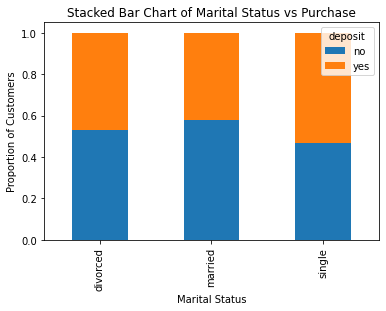

In [29]:
table=pd.crosstab(bank_cleaned.marital, bank_cleaned.deposit)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('data/marital_vs_pur_stack.png')

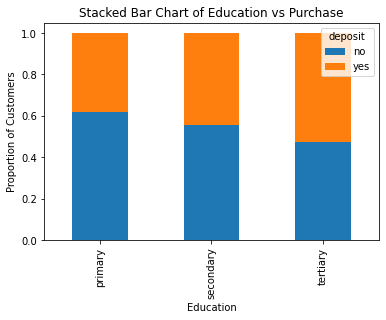

In [30]:
table=pd.crosstab(bank_cleaned.education, bank_cleaned.deposit)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('data/edu_vs_pur_stack.png')

In [31]:
# season
# 1 - winter, 2 - spring, 3 - summer, 4 - autumn
bank_cleaned['season'] = bank_cleaned['month'].apply(lambda x: 'winter' if x in ['dec', 'jan', 'feb'] else ('spring' if x in ['mar', 'apr', 'may'] else \
                                                                         ('summer' if x in ['jun', 'jul', 'aug'] else \
                                                                         ('autumn' if x in ['sep', 'oct', 'nov'] else 'other'))))

# Month
month_data = bank_cleaned.groupby('month', as_index=False)['deposit'].value_counts()

# Graph (Plotly) - bar chart
fig = px.bar(
    data_frame=month_data,
    x='month',
    y='count',
    color='deposit',
    barmode='group',
    height=400,
    width=800,
    color_discrete_map={'no':'blue', 'yes':'red'}
)

fig.update_layout(
    title='Opening a deposit by Month',
    xaxis=dict(
        title='Month',
        tickfont_size=12,
    ),
    yaxis=dict(
        title='Frequency of Purchase',
        titlefont_size=12,
        tickfont_size=12,
    ))

fig.show()
fig.write_image('data/fig3.png')

In [32]:
# Season
season_data = bank_cleaned.groupby('season', as_index=False)['deposit'].value_counts()

# Graph (Plotly) - bar chart
fig = px.bar(
    data_frame=season_data,
    x='season',
    y='count',
    color='deposit',
    barmode='group',
    height=400,
    width=800,
    color_discrete_map={'no':'blue', 'yes':'red'}
)

fig.update_layout(
    title='Opening a deposit by Season',
    xaxis=dict(
        title='Season',
        tickfont_size=12,
    ),
    yaxis=dict(
        title='Frequency of Purchase',
        titlefont_size=12,
        tickfont_size=12,
    ))

fig.show()
fig.write_image('data/fig4.png')

* The frequency of opening a deposit doesn`t depend on the Job postion of the client. In most cases, the number of clients who opened a deposit / did not open is almost the same for each Job position.
    - But there are some groups of customer who are more inclined to open a deposit:
        - retired,
        - student,
        - unemployed
    - Clients who are not inclined to open a deposit represent the following professions:
        - blue-collar,
        - enterpreneur,
        - housemaid,
        - services
    - The largest number of bank customers work in Management sphere.
* Usually, 'single' client are more inclined to open a deposit,
* The category of Education looks like a good predictor: there is a tendency of increasing the ratio of opening a deposit by increasing education level.
* Month and Season categories show interesting tendency:
*Time periods, seasons, proximity to certain holidays often influence the decision of customers to use certain services*
    - the worst month for marketing campaign is May (more than 67% of failure ratio),
    - the number of connection with clients in Winter and Autumn is rare than in Spring and Summer,
    - in Winter and Autumn the clients are more inclined to open a deposit,
    - in Spring and Summer the clients are less inclined to open a deposit. It is time for vacation, repair business, et.c. -> it has more sense to increase marketing campaign activation in Winter and Autumn seasons.

***

In [33]:
"""
What type of bank`s customer?
- Marital status & Education level
"""
# creating pivot table with Education and Marital status columns
edu_marital_data = bank_cleaned.groupby(['education', 'marital'], as_index=False)['deposit'].value_counts()
edu_marital_data

,education,marital,deposit,count
0,primary,divorced,yes,96
1,primary,divorced,no,91
2,primary,married,no,641
3,primary,married,yes,339
4,primary,single,no,100
5,primary,single,yes,82
6,secondary,divorced,no,370
7,secondary,divorced,yes,283
8,secondary,married,no,1830
9,secondary,married,yes,1289


education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


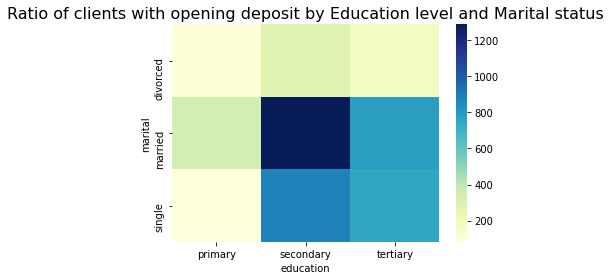

In [34]:
"""
Ratio of clients with opening deposit
"""
opened_dep = bank_cleaned[bank_cleaned['deposit'] == 'yes'].groupby('education', as_index=False)['marital'].value_counts()

pivot = opened_dep.pivot_table(
    values='count',
    columns='education',
    index='marital'
)

display(pivot)

# Graph (Seaborn) - Heat map
heatmap = sns.heatmap(
    data=pivot,
    cmap='YlGnBu'
)

heatmap.set_title('Ratio of clients with opening deposit by Education level and Marital status', fontsize=16);

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


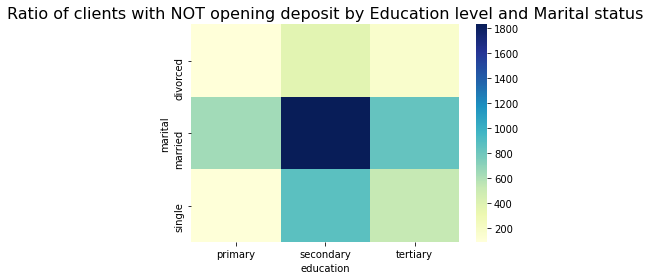

In [35]:
"""
Ratio of clients with NOT opening deposit
"""
not_dep = bank_cleaned[bank_cleaned['deposit'] == 'no'].groupby('education', as_index=False)['marital'].value_counts()

pivot = not_dep.pivot_table(
    values='count',
    columns='education',
    index='marital'
)

display(pivot)

# Graph (Seaborn) - Heat map
heatmap = sns.heatmap(
    data=pivot,
    cmap='YlGnBu'
)

heatmap.set_title('Ratio of clients with NOT opening deposit by Education level and Marital status', fontsize=16);

* Clients with 'married' status and secondary education level are typical customer of this bank.
* Clients with 'single' / 'divorced' status and 1-3 education levels are more inclined to open a deposit.

***

### `AGE`

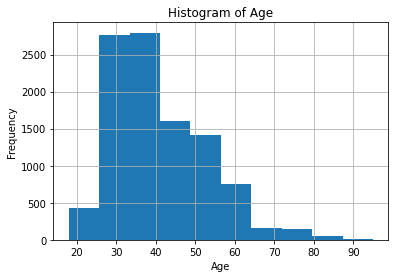

In [36]:
bank_cleaned.age.hist()

plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('data/hist_age.png')

Most of the bank’s customers in this dataset are between 25 and 40 years old

In [37]:
"""
Let`s create age group:
* '<30';
* '30-40';
* '40-50';
* '50-60';
* '60+'
We can transform age in to categories by cut() method from Pandas
-> using Pivot tables/ bar charts
"""
def get_age_group(age):
    if age < 30:
        age = '< 30'
    elif 30 <= age < 40:
        age = '30-39'
    elif 40 <= age < 50:
        age = '40-49'
    elif 50 <= age <= 60:
        age = '50-60'
    elif age > 60:
        age = '60+'
    
    return age

   
bank_cleaned['age_group'] = bank_cleaned.age.apply(get_age_group)

In [38]:
age_data = bank_cleaned.groupby('age_group')['deposit'].value_counts(True)
age_data

age_group  deposit
30-39      no         0.566776
           yes        0.433224
40-49      no         0.606213
           yes        0.393787
50-60      no         0.581940
           yes        0.418060
60+        yes        0.810916
           no         0.189084
< 30       yes        0.591753
           no         0.408247
Name: deposit, dtype: float64

* The age of clients who opened a deposit is in the next age range: less than 30 and 60+.

***

### `POUTCOME`

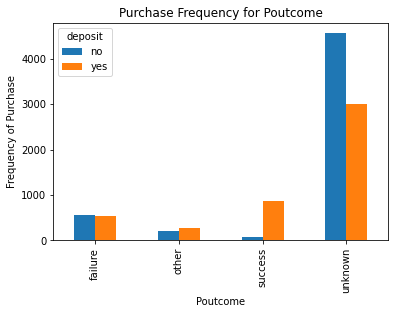

In [39]:
pd.crosstab(bank_cleaned.poutcome, bank_cleaned.deposit).plot(kind='bar')

plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('data/pur_fre_pout_bar.png')

Poutcome looks like a good predictor.

***

# <p style="text-align:center;font-size:100%;">3. Feature Encoding</p>

In [40]:
# Let's make a copy of df
bank_encoding = bank_cleaned.copy()

In [41]:
bank_encoding

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,season,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,spring,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,spring,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,spring,40-49
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,spring,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,spring,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,spring,30-39
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,summer,30-39
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,summer,30-39
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,spring,40-49


In [42]:
import category_encoders as ce

ord_encoder = ce.OrdinalEncoder()

bank_encoding['edu_cat'] = ord_encoder.fit_transform(bank_encoding['education'])
bank_encoding['age_cat'] = ord_encoder.fit_transform(bank_encoding['age_group'])

bank_encoding.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,deposit,season,age_group,edu_cat,age_cat
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,...,1042,1,-1,0,unknown,yes,spring,50-60,1,1
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,...,1467,1,-1,0,unknown,yes,spring,50-60,1,1
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,...,1389,1,-1,0,unknown,yes,spring,40-49,1,2
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,...,579,1,-1,0,unknown,yes,spring,50-60,1,1
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,...,673,2,-1,0,unknown,yes,spring,50-60,2,1
5,42,management,single,tertiary,no,0.0,yes,yes,unknown,5,...,562,2,-1,0,unknown,yes,spring,40-49,2,2
6,56,management,married,tertiary,no,830.0,yes,yes,unknown,6,...,1201,1,-1,0,unknown,yes,spring,50-60,2,1
7,60,retired,divorced,secondary,no,545.0,yes,no,unknown,6,...,1030,1,-1,0,unknown,yes,spring,50-60,1,1
8,37,technician,married,secondary,no,1.0,yes,no,unknown,6,...,608,1,-1,0,unknown,yes,spring,30-39,1,3
9,28,services,single,secondary,no,550.0,yes,no,unknown,6,...,1297,3,-1,0,unknown,yes,spring,< 30,1,4


In [43]:
# Encoding of Binary categorical features to 1/0
bank_encoding['housing'] = bank_encoding['housing'].apply(lambda x: 1 if x == 'yes' else 0)
bank_encoding['loan'] = bank_encoding['loan'].apply(lambda x: 1 if x == 'yes' else 0)
bank_encoding['default'] = bank_encoding['default'].apply(lambda x: 1 if x == 'yes' else 0)

bank_encoding['deposit'] = bank_encoding['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

bank_encoding.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,deposit,season,age_group,edu_cat,age_cat
0,59,admin.,married,secondary,0,2343.0,1,0,unknown,5,...,1042,1,-1,0,unknown,1,spring,50-60,1,1
1,56,admin.,married,secondary,0,45.0,0,0,unknown,5,...,1467,1,-1,0,unknown,1,spring,50-60,1,1
2,41,technician,married,secondary,0,1270.0,1,0,unknown,5,...,1389,1,-1,0,unknown,1,spring,40-49,1,2


In [44]:
bank_encoding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  int64  
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  int64  
 7   loan       10105 non-null  int64  
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  int64  
 17  season     10105 non-null  object 
 18  age_group  10105 non-null  object 
 19  edu_cat    10105 non-null  int32  
 20  age_ca

***

Let`s look at the correlation between features and target (numeric data) using Heatmap.

*Before creating new columns by OneHot encoding method*

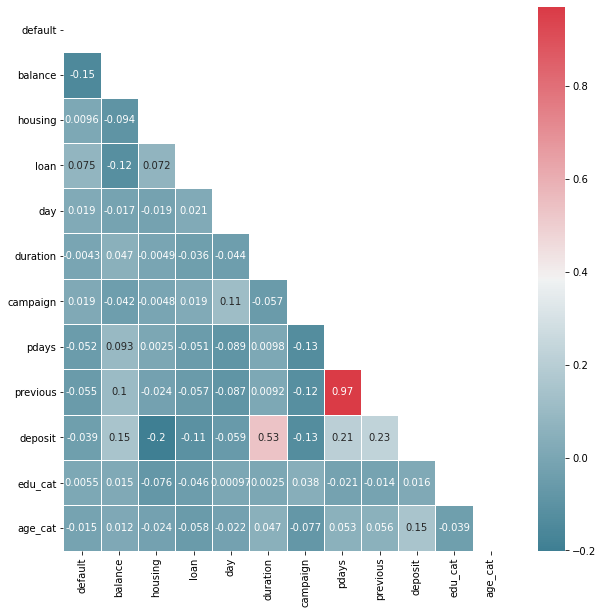

In [45]:
# Creating correlation heatmap: numeric data
num_features = bank_encoding[['default', 'balance', 'housing', 'loan', 'day',
                              'month', 'duration', 'campaign', 'pdays', 'previous',
                              'deposit', 'edu_cat', 'age_cat']]

# Params for graph: color, single corner
mask = np.zeros_like(num_features.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(num_features.corr(method='spearman'), mask=mask, cmap=cmap, linewidths=.6, annot=True, ax=ax)

plt.show();

* There is average level of correlation between *deposit* - *duration* feature (0.53)
* There is strong correlation between *pdays - previous*. At the Feature selection step it is necessary to remove one of this features. Because strong correlation means data multicollinearity.

***

Encoding nominal variables (more than 2 categories):
* 'job',
* 'marital',
* 'contact',
* 'month',
* 'season',
* 'poutcome'.

In [46]:
# dummy-features
bank_encoding = pd.get_dummies(bank_encoding, columns=['job', 'marital', 'contact', 'month', 'poutcome', 'season'], drop_first=False)

In [47]:
bank_encoding

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,season_autumn,season_spring,season_summer,season_winter
0,59,secondary,0,2343.0,1,0,5,1042,1,-1,...,0,0,0,0,0,1,0,1,0,0
1,56,secondary,0,45.0,0,0,5,1467,1,-1,...,0,0,0,0,0,1,0,1,0,0
2,41,secondary,0,1270.0,1,0,5,1389,1,-1,...,0,0,0,0,0,1,0,1,0,0
3,55,secondary,0,2476.0,1,0,5,579,1,-1,...,0,0,0,0,0,1,0,1,0,0
4,54,tertiary,0,184.0,0,0,5,673,2,-1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,primary,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,1,0,1,0,0
11158,39,secondary,0,733.0,0,0,16,83,4,-1,...,0,0,0,0,0,1,0,0,1,0
11159,32,secondary,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,1,0,0,1,0
11160,43,secondary,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,0,1,0,0


In [48]:
bank_final = bank_encoding.drop(columns=['age', 'education', 'age_group'])
bank_final

,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,...,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,season_autumn,season_spring,season_summer,season_winter
0,0,2343.0,1,0,5,1042,1,-1,0,1,...,0,0,0,0,0,1,0,1,0,0
1,0,45.0,0,0,5,1467,1,-1,0,1,...,0,0,0,0,0,1,0,1,0,0
2,0,1270.0,1,0,5,1389,1,-1,0,1,...,0,0,0,0,0,1,0,1,0,0
3,0,2476.0,1,0,5,579,1,-1,0,1,...,0,0,0,0,0,1,0,1,0,0
4,0,184.0,0,0,5,673,2,-1,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,1.0,1,0,20,257,1,-1,0,0,...,0,0,0,0,0,1,0,1,0,0
11158,0,733.0,0,0,16,83,4,-1,0,0,...,0,0,0,0,0,1,0,0,1,0
11159,0,29.0,0,0,19,156,2,-1,0,0,...,0,0,0,0,0,1,0,0,1,0
11160,0,0.0,0,1,8,9,2,172,5,0,...,0,0,1,0,0,0,0,1,0,0


<AxesSubplot: >

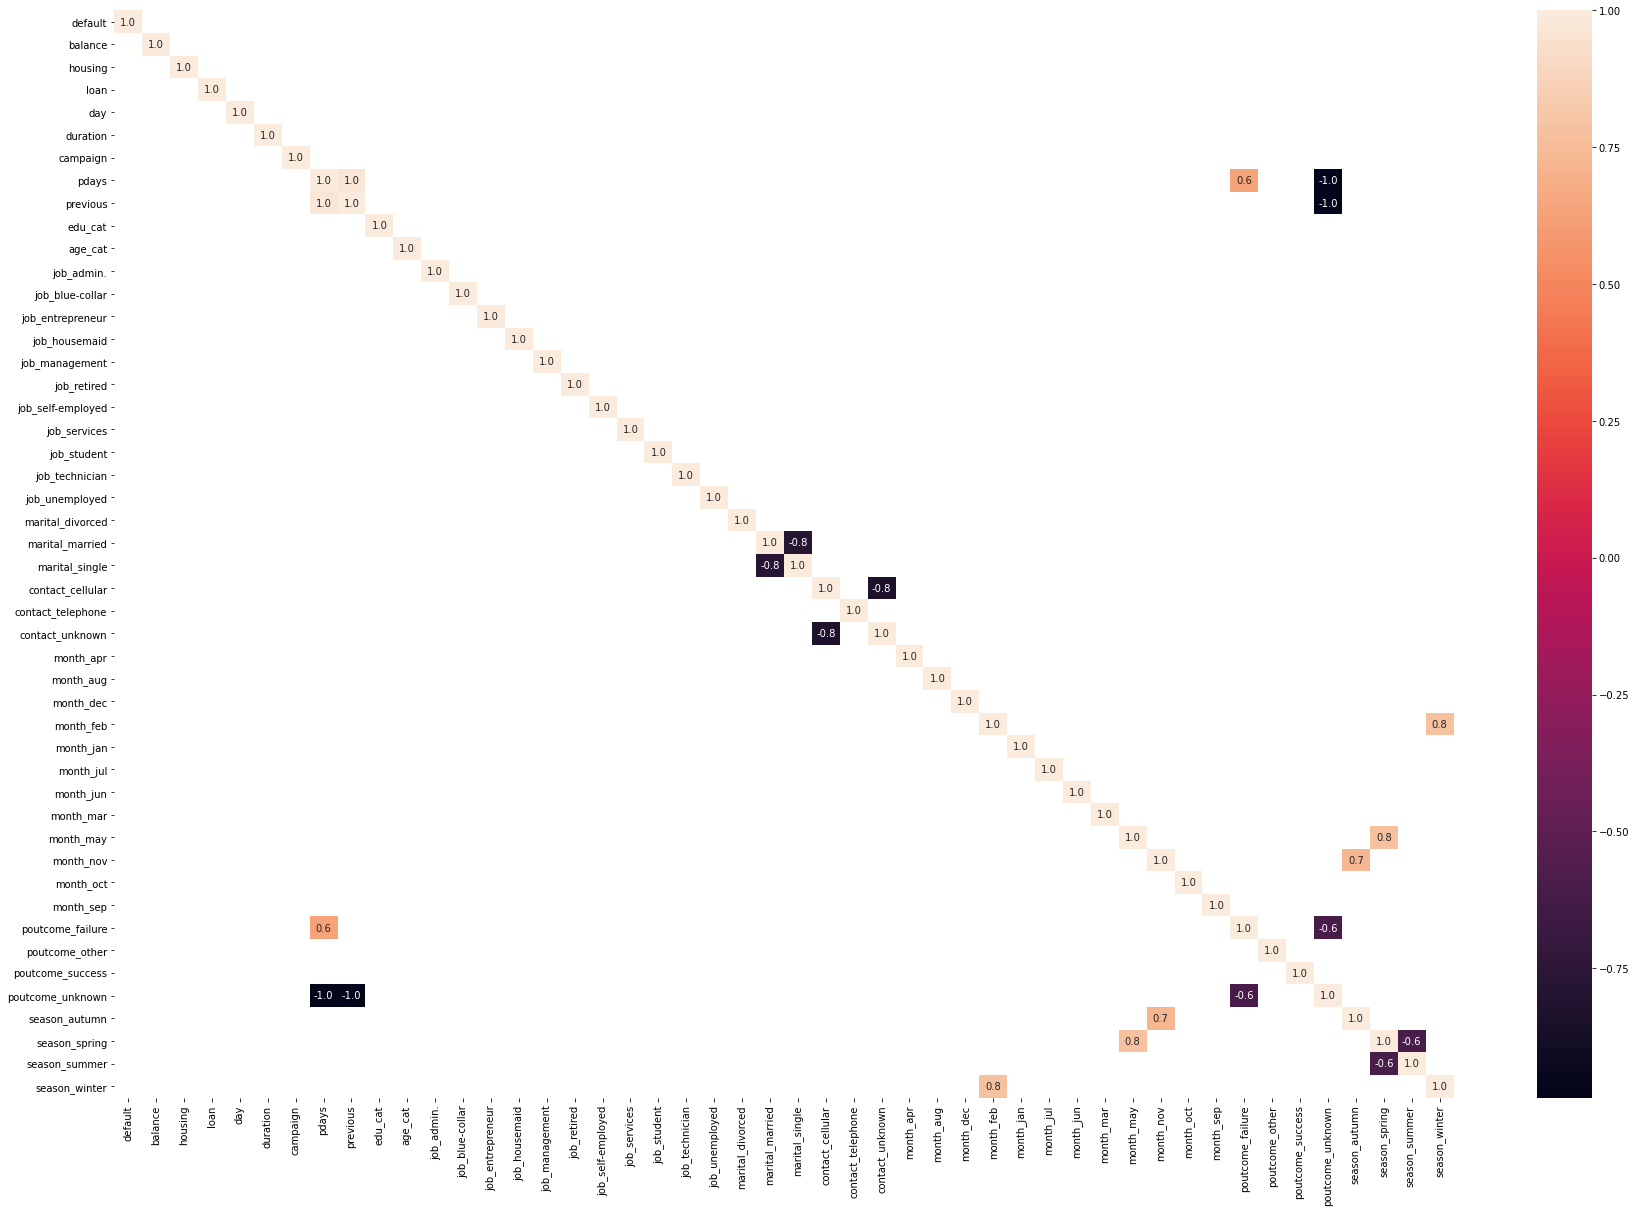

In [49]:
"""
Let`s check multicorrelation between features
"""
corr_data = bank_final.drop(columns='deposit', axis=1).corr(method='spearman')

plt.rcParams['figure.figsize'] = (30,20)

sns.heatmap(corr_data[corr_data.abs() > 0.6], annot = True,  fmt='.1f')

* There is strong correlation between the next paar:
    - previous-pdays - positive correlation
    - positive correlation between features Month and Season
    - poutcome_unknown-pdays - negative correlation
    - poutcome_unknown-previous - negative correlation
    - marital_married-marital_single - negative correlation
    - contact_cellular-contact_unknown - negative correlation

***

# <p style="text-align:center;font-size:100%;">4. Feature Selection</p>

In [50]:
X = bank_final.drop(['pdays', 'deposit'], axis=1) # remove pdays column
y = bank_final['deposit'] # target value

# dividing for train и validation data (67/33) 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_SEED, test_size=0.33)

In [51]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6770, 47) (6770,) (3335, 47) (3335,)


In [52]:
"""
Let`s check more meaningful features using SelectKBest 
"""
selector = SelectKBest(score_func = f_classif, k=20)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'age_cat', 'job_blue-collar', 'job_retired', 'job_student',
       'contact_cellular', 'contact_unknown', 'month_apr', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'season_autumn'], dtype=object)

In [53]:
"""
Let`s get more 20 meaningful features by SelectKBest
+ add the next featutes:
- marital status
- education level
"""
X_train = X_train[['balance', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'age_cat', 'job_blue-collar', 'job_retired', 'job_student',
       'contact_cellular', 'contact_unknown', 'month_apr', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'season_autumn', 'edu_cat',
       'marital_single', 'marital_divorced']]

X_test = X_test[['balance', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'age_cat', 'job_blue-collar', 'job_retired', 'job_student',
       'contact_cellular', 'contact_unknown', 'month_apr', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'season_autumn', 'edu_cat',
       'marital_single', 'marital_divorced']]

In [54]:
# Data Normalization: minmaxsxaler
mm_scaler = MinMaxScaler()

mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test) 

print(round(X_test_scaled[:, 0].mean(), 2))

0.47


# <p style="text-align:center;font-size:100%;">5. Classification ML models: Logistic Regression and Decision Tree</p>

In [55]:
# Model
lr_model = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=RANDOM_SEED
    )

# Training model: target -> logloss minimization
log_reg = lr_model.fit(X_train_scaled, y_train)

# Get prediction of class
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

# F1_score computing
print('Logistic Regression:')
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.76      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Logistic Regression:
F1-score train: 0.81
F1-score train: 0.79


In [56]:
# DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', # informative criterion 
    random_state=RANDOM_SEED
)

# Training Decision Tree by CART algorithm
dt_clf.fit(X_train_scaled, y_train)

# Get class prediction
y_train_pred = dt_clf.predict(X_train_scaled)
y_test_pred = dt_clf.predict(X_test_scaled)

# F1_score computing
print('Decision Tree (parameters by default):')
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Decision Tree (parameters by default):
F1-score train: 1.00
F1-score test: 0.74


In [57]:
# DecisionTreeClassifier: max_depth=6
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=RANDOM_SEED
)

# Training Decision Tree
dt_clf.fit(X_train_scaled, y_train)

# Get class prediction
y_train_pred = dt_clf.predict(X_train_scaled)
y_test_pred = dt_clf.predict(X_test_scaled)

# F1_score computing
print('Decision Tree (max_depth=6):')
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Decision Tree (max_depth=6):
F1-score train: 0.81
F1-score test: 0.80


In [58]:
# Optimisation of Hypermarameters: GridSearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=RANDOM_SEED,
        criterion='entropy'
    ),
    param_grid=param_grid,
    n_jobs = -1
)

# choose the Best Hyperparameter Values based on metrics result
%time grid_search.fit(X_train_scaled, y_train)

y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)

print('Decision Tree (Optimisation of Hypermarameters by GridSearch):')
print('f1_score (train): {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score (test): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('\nBest Hyperparameter Values: {}'.format(grid_search.best_params_))

Wall time: 4.95 s
Decision Tree (Optimisation of Hypermarameters by GridSearch):
f1_score (train): 0.83
f1_score (test): 0.81

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}


In [59]:
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_split=10,
    random_state=RANDOM_SEED
)

# Training Decision Tree
dt_clf.fit(X_train_scaled, y_train)

# Get class prediction
y_train_pred = dt_clf.predict(X_train_scaled)
y_test_pred = dt_clf.predict(X_test_scaled)

# F1_score computing
print('Decision Tree (max_depth=7, min_samples_split=10):')
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Decision Tree (max_depth=7, min_samples_split=10):
F1-score train: 0.83
F1-score test: 0.81


# <p style="text-align:center;font-size:100%;">6. Classification ML models: Ensembles</p>

### `RANDOM FOREST`

In [60]:
# Model: RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=RANDOM_SEED
    )


rf_model.fit(X_train_scaled, y_train)

# Get class prediction
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Report of metrics result
print(metrics.classification_report(y_test, y_test_pred))

# Recall computing
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

# F1_score computing
print('\nRandom Forest (max_depth=10, min_samples_leaf=5, n_estimators=100):')
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

Recall: 0.85

Random Forest (max_depth=10, min_samples_leaf=5, n_estimators=100):
F1-score train: 0.85
F1-score test: 0.83


### `GRADIENT BOOSTING`

In [61]:
# Model: GradientBoostingClassifier
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    max_depth=5,
    min_samples_leaf = 5,
    n_estimators=300, # number of estimators in ensemble
    random_state=RANDOM_SEED
)

# Model training
gb.fit(X_train_scaled, y_train)

# Getting prediction for test
y_test_pred = gb.predict(X_test_scaled)

# Report of metrics result
print(metrics.classification_report(y_test, y_test_pred))
print('\nGradient Boosting (max_depth=5, min_samples_leaf=5, n_estimators=300, learning_rate=0.05):')
print('F1-score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335


Gradient Boosting (max_depth=5, min_samples_leaf=5, n_estimators=300, learning_rate=0.05):
F1-score train: 0.85
F1-score test: 0.83


### `STACKING`

In [62]:
# Model: Stacking: DecisionTreeClassifier, GradientBoostingClassifier
estimators = [
    ('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                      max_depth=7,
                                      min_samples_split=7,
                                      random_state=RANDOM_SEED)),
    ('gb', GradientBoostingClassifier(learning_rate = 0.05,
                                      max_depth=5,
                                      min_samples_leaf=5,
                                      n_estimators=300,
                                      random_state=RANDOM_SEED))
]

# Object of Stacking class
stack_clas = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(max_iter=1000,
                                                    solver='sag',
                                                    random_state=RANDOM_SEED)
    )

# Model training
stack_clas.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=7,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [63]:
# Getting prediction for test data
y_test_pred = stack_clas.predict(X_test_scaled)

# Report of metrics result
print(metrics.classification_report(y_test, y_test_pred))

print('\nStacking:')
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('\nF1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1790
           1       0.82      0.84      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335


Stacking:
Precision test: 0.82

F1_score train: 0.85
F1_score test: 0.83


In [64]:
# What kind of features are more meaningful in GradientBoosting model?
gb.feature_importances_

array([0.05568708, 0.05106554, 0.00888797, 0.48823845, 0.01401131,
       0.036205  , 0.04364804, 0.00242309, 0.00247704, 0.00187294,
       0.00553276, 0.06935934, 0.01679345, 0.02574193, 0.01436747,
       0.01919716, 0.01241936, 0.11071126, 0.00223183, 0.00859129,
       0.00519864, 0.00403246, 0.00130657])

In [65]:
X_train.columns

Index(['balance', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'age_cat', 'job_blue-collar', 'job_retired', 'job_student',
       'contact_cellular', 'contact_unknown', 'month_apr', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'season_autumn', 'edu_cat', 'marital_single',
       'marital_divorced'],
      dtype='object')

***

In [66]:
"""
Hyperparameter Optimization by Optuna
"""
# print("Optuna version: {}".format(optuna.__version__))

"""
Set up Hyperparameter Optimization for the Random Forest
"""
def optuna_rf(trial):
  # define hyperparameter search spaces
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # creating Model
  model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=RANDOM_SEED)
  # Training model
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [67]:
%%time

# create an object of study
# need to maximize the metric - direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# looking for the best combination of hyperparameters n_trials
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-04 17:00:28,340] A new study created in memory with name: RandomForestClassifier
[I 2023-05-04 17:00:29,209] Trial 0 finished with value: 0.8631054352904532 and parameters: {'n_estimators': 106, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8631054352904532.
[I 2023-05-04 17:00:30,091] Trial 1 finished with value: 0.8636576604716539 and parameters: {'n_estimators': 141, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8636576604716539.
[I 2023-05-04 17:00:31,598] Trial 2 finished with value: 0.9009514896272032 and parameters: {'n_estimators': 145, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9009514896272032.
[I 2023-05-04 17:00:32,800] Trial 3 finished with value: 0.8736496007515265 and parameters: {'n_estimators': 184, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9009514896272032.
[I 2023-05-04 17:00:33,573] Trial 4 finished with value: 0.9205548549810846 and parameters: {'n_

Wall time: 20 s


In [68]:
print('The Best Hyperparameter Values {}'.format(study.best_params))
print('f1_score (train data): {:.2f}'.format(study.best_value))

The Best Hyperparameter Values {'n_estimators': 188, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score (train data): 0.93


In [69]:
# Accuracy computing on test data
model = RandomForestClassifier(**study.best_params, random_state=RANDOM_SEED)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
print('Accuracy on test data: {:.2f}'.format(model.score(X_test_scaled, y_test)))

y_test_pred = model.predict(X_test_scaled)
print('\nRandom Forest (Optimisation of Hypermarameters by Optuna):')
print('\nf1_score on train data: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score on test data: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy on test data: 0.84

Random Forest (Optimisation of Hypermarameters by Optuna):

f1_score on train data: 0.93
f1_score on test data: 0.83


***

In [70]:
result = pd.DataFrame({
    'Model Name': ['Logistic Regression (base)', 'Decision Tree (by default)', 'Decision Tree (2)', 'Decision Tree (optimization by GridSearch)',
                   'Random Forest', 'Gradient Boosting', 'Stacking', 'Random Forest (optimization by Optuna)'],
    'Hyperparameters': ['', '', 'max_depth=6', 'max_depth=7, min_samples_split=10', 'max_depth=10, min_samples_leaf=5, n_estimators=100',
                        'learning_rate=0.05, max_depth=5, min_samples_leaf=5, n_estimators=300', 'as in Decision Tree (by GridSearch) and Gradient Boosting',
                        'n_estimators=134, max_depth=25, min_samples_leaf=2'],
    'F1_score, train': ['0.81', '1.00', '0.81', '0.83', '0.85', '0.85', '0.85', '0.93'],
    'F1_score, test': ['0.79', '0.74', '0.80', '0.81', '0.83', '0.83', '0.83', '0.83']
})

display(result)

,Model Name,Hyperparameters,"F1_score, train","F1_score, test"
0,Logistic Regression (base),,0.81,0.79
1,Decision Tree (by default),,1.00,0.74
2,Decision Tree (2),max_depth=6,0.81,0.80
3,Decision Tree (optimization by GridSearch),"max_depth=7, min_samples_split=10",0.83,0.81
4,Random Forest,"max_depth=10, min_samples_leaf=5, n_estimators...",0.85,0.83
5,Gradient Boosting,"learning_rate=0.05, max_depth=5, min_samples_l...",0.85,0.83
6,Stacking,as in Decision Tree (by GridSearch) and Gradie...,0.85,0.83
7,Random Forest (optimization by Optuna),"n_estimators=134, max_depth=25, min_samples_le...",0.93,0.83


Based on the F1_score values, I can conclude that the best results show Ensemble models: Random Forest, Gradient Boosting, Stacking.

But anyway it is not a high rate of prediction (0.83 for test data). It`s necessary to do in-depth analysis of data/ creating new features further.